In [11]:
%matplotlib inline

## Necessary Imports

In [12]:
import os
import posixpath
import requests

import pandas as pd

from urllib.parse import urlencode

## Parameters
___
Set parameters here to match the analysis you'd like to preform.

In [13]:
# Year of 311 complaints to explore
year = 2017
# Number of top comlaints to use in part 1
part_1_top_complaints = 10
# Number of top complaints to use in part 2
part_2_top_complaints = 10
# Number of top zip codes to use in part 2
part_2_top_zips = 10
# When fetching data, whether or not to bother checking for data locally before hitting the apis
overwrite_311 = True
overwrite_census = True

## Constants
___
Important constants, do not alter if not necessary.

In [60]:
api_url_311 = 'https://data.cityofnewyork.us/resource/fhrw-4uyv.json'
api_url_census = 'https://api.census.gov/data/2010/sf1?get=P0010001&for=zip%20code%20tabulation%20area:*&in=state:36'
api_headers = {'X-App-Token': 'nsmatxqj7NfjKxyB93xrdttB8'}

## Fetching Data

In [15]:
if overwrite_311 or not os.path.isfile('explore311.complaints.csv'):
    # First get the count of records to fetch, as the default is 1000
    count_dict_311 = {'$select': 'count(unique_key)', '$where': f'date_extract_y(created_date) = {str(year)}'}
    count_311 = requests.get(
        posixpath.join(api_url_311, f'?{urlencode(count_dict_311)}'), headers=api_headers).json()[0]['count_unique_key']

    query_dict_311 = {'$select': 'complaint_type, incident_zip, borough', 
                      '$where': f'date_extract_y(created_date) = {str(year)}', '$limit': count_311}
    data_311 = pd.DataFrame(requests.get(
        posixpath.join(api_url_311, f'?{urlencode(query_dict_311)}'), headers=api_headers).json())
    
    # Parse the zip code field using str.extract, a vectorized regex function
    data_311['incident_zip'] = data_311.incident_zip.str.extract(r'(\d{5})', expand=False)
    
    data_311.to_csv('explore311.complaints.csv', index=False)
else:
    data_311 = pd.read_csv('explore311.complaints.csv', dtype=str)

In [90]:
if overwrite_census or not os.path.isfile('explore311.census.csv'):
    
    data_census = pd.DataFrame(requests.get(api_url_census).json())
    
    # The census api returns lists of rows, so some formatting must be done
    data_census = data_census.drop(0).drop(1, axis=1).rename(columns={0: 'population', 2: 'zip'}).set_index('zip')
    
    # It also returns all zip codes within NY. Filter out zips that aren't in the 311 data
    data_census = data_census[data_census.index.isin(data_311.incident_zip)]
    
    data_census['population'] = data_census.population.astype(int)
                               
    data_census.to_csv('explore311.census.csv')
else:
    data_census = pd.read_csv('explore311.census.csv', dtype={'count_participants': int})

# Part 1
___
_Consider only the 10 most common overall complaint types. For each borough, how many of each of those 10 types were there in 2017?_

### First, let's see what boroughs are included in the data set.

In [21]:
data_311.borough.unique()

array(['BROOKLYN', 'MANHATTAN', 'BRONX', 'QUEENS', 'STATEN ISLAND',
       'Unspecified'], dtype=object)

### We don't care about `Unspecified` as it's not a borough. Filter it out. Also, we'll only need the `complaint_type` and `borough` features for this task, so let's select them.

In [22]:
data_311_1 = data_311[data_311.borough != 'Unspecified'][['complaint_type', 'borough']].copy()

In [23]:
top_complaints_1 = data_311_1.groupby('complaint_type').size().nlargest(part_1_top_complaints)

### Here we can see the top n overall complaints. `Noise - Residential` is the number one complaint across all boroughs.

In [24]:
top_complaints_1

complaint_type
Noise - Residential        227295
HEAT/HOT WATER             211601
Illegal Parking            142574
Blocked Driveway           133660
Street Condition            88066
UNSANITARY CONDITION        78767
Noise - Street/Sidewalk     72133
Water System                62334
Noise                       58239
PAINT/PLASTER               56740
dtype: int64

### Now, let's filter out all the data that doesn't fit into those top n categories, then group the data by borough. Once that's done, on each borough, we group by complaint type. As we've already filtered out the complaints not in the top n, we just have to get the size of each complaint group and return it to see the numbers of complaints by complaint type by borough.

In [25]:
borough_counts = data_311_1[data_311_1.complaint_type.isin(top_complaints_1.index)].groupby('borough')\
    .apply(lambda borough: borough.groupby('complaint_type').size())

In [26]:
borough_counts

complaint_type,Blocked Driveway,HEAT/HOT WATER,Illegal Parking,Noise,Noise - Residential,Noise - Street/Sidewalk,PAINT/PLASTER,Street Condition,UNSANITARY CONDITION,Water System
borough,,,,,,,,,,
BRONX,24024,67934,15705,3013,57028,13977,19310,10908,24315,9823
BROOKLYN,48866,66268,54895,14769,66821,20971,19323,24580,26542,19107
MANHATTAN,3401,46210,19274,28235,50657,28908,11435,14031,14516,10427
QUEENS,54058,29127,45658,10401,46229,7480,5670,28955,11458,18066
STATEN ISLAND,3311,2062,7042,1821,6560,797,1002,9592,1936,4911


### A stacked bar chart will make it easier to see how each borough ranks in complaints and how the complaint types rank within each borough.

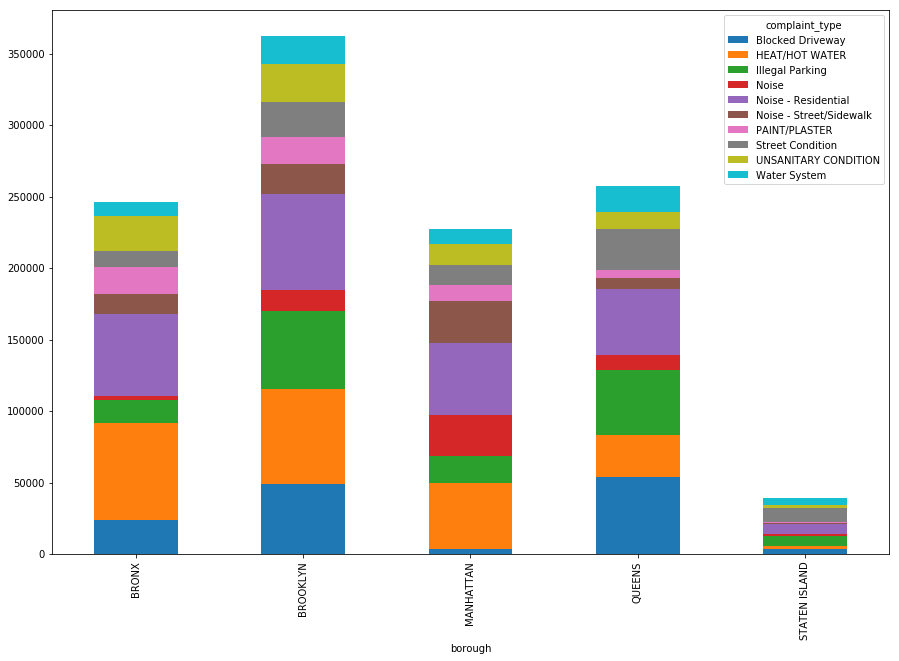

In [27]:
borough_counts.plot.bar(stacked=True, figsize=(15, 10))

# Part 2
___
_Consider only the 10 most common overall complaint types.  For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?_

### For this part, we only need `complaint_type` and `incident_zip` to complete the analysis.

In [68]:
data_311_2 = data_311[['complaint_type', 'incident_zip']].copy()

In [69]:
top_complaints_2 = data_311_2.groupby('complaint_type').size().nlargest(part_2_top_complaints)

In [78]:
top_complaints_2

complaint_type
Noise - Residential        227688
HEAT/HOT WATER             211601
Illegal Parking            143247
Blocked Driveway           134159
Street Condition            88097
UNSANITARY CONDITION        78767
Noise - Street/Sidewalk     72165
Water System                62334
Noise                       58239
PAINT/PLASTER               56740
dtype: int64

### Just to check we've got the right population data

In [105]:
# Should be about 8.5 million
data_census.population.sum()

8540085

In [92]:
top_zips = data_census.nlargest(part_2_top_zips, 'population')

### Cross-referencing with http://www.city-data.com/zipmaps/New-York-New-York.html, these numbers look to be correct.

In [93]:
top_zips

,population
zip,
11368,109931
11226,101572
11373,100820
11220,99598
11385,98592
10467,97060
10025,94600
11208,94469
11236,93877


### Now we can do the same as before, grouping into top `zips`, then into `complaint_type`.

In [95]:
top_zips_counts = data_311_2[
    data_311_2.complaint_type.isin(top_complaints_2.index) & data_311_2.incident_zip.isin(top_zips.index)]\
    .groupby('incident_zip').apply(lambda zip: zip.groupby('complaint_type').size())

In [96]:
top_zips_counts

complaint_type,Blocked Driveway,HEAT/HOT WATER,Illegal Parking,Noise,Noise - Residential,Noise - Street/Sidewalk,PAINT/PLASTER,Street Condition,UNSANITARY CONDITION,Water System
incident_zip,,,,,,,,,,
10025,125,2397,736,1398,2085,1224,604,628,714,481
10467,2068,6041,986,285,5807,713,1955,612,2192,560
11207,2062,2461,1500,199,3061,558,1055,1142,1621,757
11208,2756,2052,2150,188,2795,825,800,816,1341,710
11220,1558,1634,2013,442,1522,498,506,690,719,674
11226,2203,7569,1076,440,4854,1831,2639,491,3155,406
11236,3041,1145,1431,108,1929,201,347,1021,562,623
11368,4384,1620,1251,158,2460,684,361,561,639,617
11373,2635,3408,1277,270,1842,304,265,691,756,372


### Here we plot the data as we did before, except here, we select the data with the index of `top_zips`. This orders the data from left to right by zip code population. Interestingly, the most populous zip code only creates the sixth most complaints of the top ten.

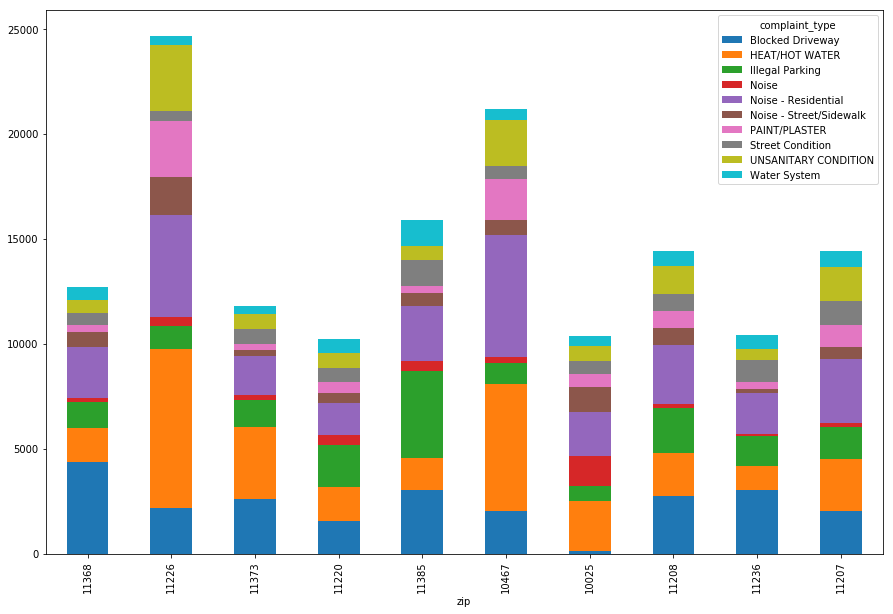

In [106]:
top_zips_counts.loc[top_zips.index].plot.bar(stacked=True, figsize=(15, 10))